In [72]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tabulate import tabulate

## Download and preprocessing



In [2]:
mid_label_map = [
            (0,      'Other'),
            (406516, 'Open Door 1'),
            (406517, 'Open Door 2'),
            (404516, 'Close Door 1'),
            (404517, 'Close Door 2'),
            (406520, 'Open Fridge'),
            (404520, 'Close Fridge'),
            (406505, 'Open Dishwasher'),
            (404505, 'Close Dishwasher'),
            (406519, 'Open Drawer 1'),
            (404519, 'Close Drawer 1'),
            (406511, 'Open Drawer 2'),
            (404511, 'Close Drawer 2'),
            (406508, 'Open Drawer 3'),
            (404508, 'Close Drawer 3'),
            (408512, 'Clean Table'),
            (407521, 'Drink from Cup'),
            (405506, 'Toggle Switch')]
mid_label_to_id = {str(x[0]): i for i, x in enumerate(mid_label_map)}
mid_idToLabel = [x[1] for x in mid_label_map]

hi_label_map = [(0, 'Other'),
                (101, 'Relaxing'), (102, 'Coffee time'),
                (103, 'Early morning'), (104, 'Cleanup'),
                (105, 'Sandwich time')]

hi_label_to_id = {str(x[0]): i for i, x in enumerate(hi_label_map)}
hi_idToLabel = [x[1] for x in hi_label_map]

loco_map = [(0, 'Other'), (1 , 'Stand'), (2,'Walk'), (4, 'Sit'), (5, 'Lie')]
loco_label_to_id = {str(x[0]): i for i, x in enumerate(loco_map)}
loco_idToLabel = [x[1] for x in loco_map]

FEATURES = [str(i) for i in range(77)]
LOCO_LABEL_COL = 77
MID_LABEL_COL = 78
HI_LABEL_COL = 79
SUBJECT_ID = 80
RUN_ID = 81

In [3]:
# !wget -q -O clean_opp.csv https://www.dropbox.com/s/uu4iz6lrzmssff8/clean_opp_nodrill.csv?dl=1

In [4]:
{i: str(x[1]) for i, x in enumerate(hi_label_map)}

{0: 'Other',
 1: 'Relaxing',
 2: 'Coffee time',
 3: 'Early morning',
 4: 'Cleanup',
 5: 'Sandwich time'}

In [5]:
df = pd.read_csv('../data/clean_opp_nodrill.csv')

In [6]:
df.shape

(630676, 82)

#### Remove null class from novelty (High level)

In [7]:
df = df[df[str(HI_LABEL_COL)] != 0]

In [8]:
df.shape

(526608, 82)

### EDA

<AxesSubplot:>

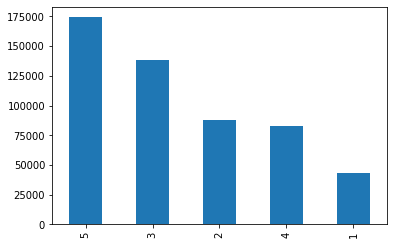

In [9]:
df.iloc[:, HI_LABEL_COL].value_counts().plot(kind='bar')

<AxesSubplot:>

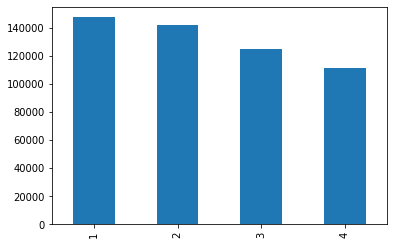

In [10]:
df.iloc[:, SUBJECT_ID].value_counts().plot(kind='bar')

### Imputation scaling

In [11]:
# Perform linear interpolation
df[FEATURES] = df[FEATURES].interpolate(method='linear', axis=0)

# Remaining missing data are converted to zero
df = df.fillna(0)

# All sensor channels are normalized
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [1]:
def get_activity_dict(activity_map:dict, novel_classes:list):
    _activity_map = activity_map.copy()
    novel_map = dict()
    
    for activity_class in novel_classes:
        novel_map[activity_class] = activity_map[activity_class]
        _activity_map.pop(activity_class)
        
    return _activity_map, novel_map

In [2]:
NOVEL_CLASSES = [2, 4]

In [3]:
activity_map = {1: 'Relaxing',2: 'Coffee time', 3: 'Early morning', 4: 'Cleanup', 5: 'Sandwich time'}
_activity_map, novel_map = get_activity_dict(activity_map, NOVEL_CLASSES)

print(_activity_map)
print(novel_map)

{1: 'Relaxing', 3: 'Early morning', 5: 'Sandwich time'}
{2: 'Coffee time', 4: 'Cleanup'}


In [4]:
import json

with open("activities/opp_activity.json", "w") as outfile:  
    json.dump(activity_map, outfile, indent = 4) 

In [15]:
holdout_data = df.loc[df[str(HI_LABEL_COL)].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

### train-test

In [16]:
BENCHMARK_TEST= ((df[str(SUBJECT_ID)] == 2) | (df[str(SUBJECT_ID)] == 3)) & ((df[str(RUN_ID)] == 4) | (df[str(RUN_ID)] == 5))

In [17]:
train_df = df[~ BENCHMARK_TEST]
test_df = df[BENCHMARK_TEST]

### Window - session

In [18]:
SLIDING_WINDOW_LENGTH = 30*30
SLIDING_WINDOW_STEP = 30*5

In [19]:
def create_windowed_dataset(df, features= FEATURES, class_label = str(HI_LABEL_COL), window_size=24, stride = 12):
    X = df[features].values
    y = df[class_label].values
    segments = []
    labels = []
    seg_start= 0
    seg_end = window_size
    mid_labels = []
    loco_labels = []
    while seg_end <= len(X):
        if len(np.unique(y[seg_start:seg_end])) == 1: #valid-window
            segments.append(X[seg_start:seg_end])
            labels.append(y[seg_start]) # doesn't matter all same labels
            mid_labels.append(df[str(MID_LABEL_COL)].values[seg_start:seg_end])
            loco_labels.append(df[str(LOCO_LABEL_COL)].values[seg_start:seg_end])

            seg_start += stride
            seg_end = seg_start + window_size

        else: #mixed- discard last few samples, move start to the new activity
            current_label = y[seg_start]
            for i in range(seg_start, seg_end):
                if y[i] != current_label:
                    seg_start = i
                    seg_end = seg_start + window_size
                    break

    return np.asarray(segments).astype(np.float32), np.asarray(labels), mid_labels, loco_labels

In [21]:
X_train, y_train, m_labels_tr, loco_labels_tr = create_windowed_dataset(train_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
X_test, y_test, m_labels_ts, loco_labels_ts = create_windowed_dataset(test_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
X_holdout, y_holdout, m_labels_holdout, loco_labels_holdout = create_windowed_dataset(novel_data, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)

In [22]:
def plot_opp_midlevel(idx):
    print('Hi lavel activity: ', y_test[idx])
    plt.figure(figsize=(12,5))
    plt.scatter(np.linspace(0,30,num=900),m_labels_ts[idx], color='g',linewidth=0.5)
    plt.yticks(range(18),labels=mid_idToLabel)
    plt.grid(True, axis='y',  linestyle='--')
    plt.show()

In [23]:
# plot_opp_midlevel(44)

In [24]:
def plot_opp_locomotion(idx):
    plt.figure(figsize=(8,5))
    plt.scatter(np.linspace(0,30,num=900),loco_labels_ts[idx], color='g',linewidth=0.5)
    plt.yticks(range(5),labels=loco_idToLabel)
    plt.grid(True, axis='y',  linestyle='--')
    plt.show()

In [25]:
# plot_opp_locomotion(44)

In [26]:
# count = 1
# prev = y_train[0]
# for wndw in y_train:
#     if wndw != 0:
#         if wndw == prev:
#             count+=1
#         else:
#             print(f'{hi_idToLabel[prev]} -  {count/32} seconds')
#             count=1
#         prev=wndw

In [27]:
N_WINDOW = 36
N_TIMESTEP = 25

In [28]:
X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 77))
# X_val = X_val.reshape((X_val.shape[0], N_WINDOW, N_TIMESTEP, 77))
X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 77))
X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, 77))


y_train = tf.keras.utils.to_categorical(y_train)
# y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)
y_holdout = tf.keras.utils.to_categorical(y_holdout)

In [29]:
print(X_train.shape)
print(y_train.shape)

# print(X_val.shape)
# print(y_val.shape)

print(X_test.shape)
print(y_test.shape)


print(X_holdout.shape)
print(y_holdout.shape)

(1617, 36, 25, 77)
(1617, 6)
(417, 36, 25, 77)
(417, 6)
(916, 36, 25, 77)
(916, 5)


## Attention Model

In [30]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",
                                     shape=[1, 1, self.d_model],
                                     initializer=tf.keras.initializers.Orthogonal())  
    
    def call(self, v, k):
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

### Self Attention

In [31]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [32]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [33]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [34]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [35]:
class CombinedSensorSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate, concat=True):
        super(CombinedSensorSelfAttention, self).__init__()
        self.concat = concat
        self.agr_attn = AggregateAttention(d_model, num_heads)
        self.ffn1 = point_wise_feed_forward_network(d_model, dff)
        self.ffn2 = point_wise_feed_forward_network(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x):
        if self.concat:
            x = tf.concat(x, axis=1)
        x = self.ffn1(x)
        x, attn_score = self.agr_attn(x, x)
        x = self.dropout1(x)
        ffn_output = self.ffn2(x)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm(ffn_output + x)  # (batch_size, d_model)
        return out, attn_score

In [36]:
class DataTransform(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(DataTransform, self).__init__()
        # self.ln = tf.keras.layers.LayerNormalization()
        self.conv_1d = tf.keras.layers.Conv1D(d_model, 1, activation='relu')
    
    def call(self, x):
        # x = self.ln(x)
        x = self.conv_1d(x)
        return x

In [37]:
class ModalityEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=2, dropout_rate=0.1):
        super(ModalityEncoderBlock, self).__init__()
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.look_ahead_mask = create_look_ahead_mask(n_timesteps)
        self.data_transform = DataTransform(d_model)
        self.pe = PositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
        self.num_sa_blocks = num_sa_blocks
        self.self_attn_blocks = [ SelfAttentionBlock(d_model, num_heads, dff, dropout_rate)
                                        for _ in range(self.num_sa_blocks)]
        # self.agr_attn = AttentionWithContext(return_attention=True)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.data_transform(x)
        x = self.pe(x)
        for i in range(self.num_sa_blocks):
            # x = self.self_attn_blocks[i](x, mask=self.look_ahead_mask)
            x = self.self_attn_blocks[i](x)
        return x


    def compute_output_shape(x, input_shape):
        return tf.TensorShape([input_shape[0], self.d_model])

In [38]:
def get_modality_encoder(modality_indices, n_timesteps, n_features,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    num_modality = len(modality_indices)-1
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    attn_scores = []
    modality_outputs = []
    for i in range(num_modality):
            modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
            modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
            modality_outputs.append(modality_x)
    model = tf.keras.Model(inputs=inputs, outputs=modality_outputs)
    return model

In [39]:
class MultiWindowEncoder(tf.keras.layers.Layer):
    def __init__(self, modality_indices, n_window, n_timesteps, n_features, d_model, num_heads, dff, dropout_rate=0.1):
        super(MultiWindowEncoder, self).__init__()
        self.n_window = n_window
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.window_encoder = get_modality_encoder(modality_indices,n_timesteps=n_timesteps, n_features=n_features, d_model=d_model, num_heads = num_heads, dff=dff, dropout_rate=dropout_rate)
        self.combined_sensor_attn = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        feature_dim = tf.shape(x)[-1]
        x = tf.reshape(x, (-1, self.n_timesteps, feature_dim)) # all sessions in batch dim
        x = self.window_encoder(x)
        x, attn_scores = self.combined_sensor_attn(x)
        x = tf.reshape(x, (batch_size, -1, self.d_model))
        attn_scores = tf.reshape(attn_scores, (batch_size, -1, self.n_timesteps))
        return x, attn_scores

In [40]:
def get_modality_model_w_time_hierarchy(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=False) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

## Training

In [41]:
tf.keras.backend.clear_session()

n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]

# Create a MirroredStrategy.
# device_list = ['/gpu:'+str(i) for i in range(5,8)]
# strategy = tf.distribute.MirroredStrategy(devices=device_list)
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# with strategy.scope():

model = get_modality_model_w_time_hierarchy([0,9,18,27,36,45,61,77], n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics='accuracy')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 25, 77)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 787200    
_________________________________________________________________
modality_encoder_block_7 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82944     
_________________________________________________________________
dense_112 (Dense)            (None, 6)                 390       
Total params: 974,534
Trainable params: 974,534
Non-trainable params: 0
_________________________________________________________________


In [43]:
verbose, epochs, batch_size = 1, 35, 64
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,verbose=1, mode='max')
# mcp_save = ModelCheckpoint('test_3_best.hdf5', save_best_only=True, monitor='val_acc', mode='max')
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1, use_multiprocessing=True)

Epoch 1/35
23/23 [==============================] - 5s 200ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0735 - val_accuracy: 0.9877
Epoch 2/35
23/23 [==============================] - 5s 201ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1049 - val_accuracy: 0.9815
Epoch 3/35
23/23 [==============================] - 5s 200ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0877 - val_accuracy: 0.9815
Epoch 4/35
23/23 [==============================] - 5s 199ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1226 - val_accuracy: 0.9815
Epoch 5/35
23/23 [==============================] - 5s 201ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9877
Epoch 6/35
23/23 [==============================] - 5s 201ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0872 - val_accuracy: 0.9877
Epoch 7/35
23/23 [==============================] - 5s 200ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1393 - val_accuracy: 0.9691
Epoch 

In [45]:
pred = model.predict(X_test, batch_size=64)

In [49]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=_activity_map.values()))

               precision    recall  f1-score   support

     Relaxing       1.00      0.93      0.96        40
Early morning       0.97      0.97      0.97       146
Sandwich time       0.98      1.00      0.99       231

     accuracy                           0.98       417
    macro avg       0.99      0.96      0.97       417
 weighted avg       0.98      0.98      0.98       417



<AxesSubplot:>

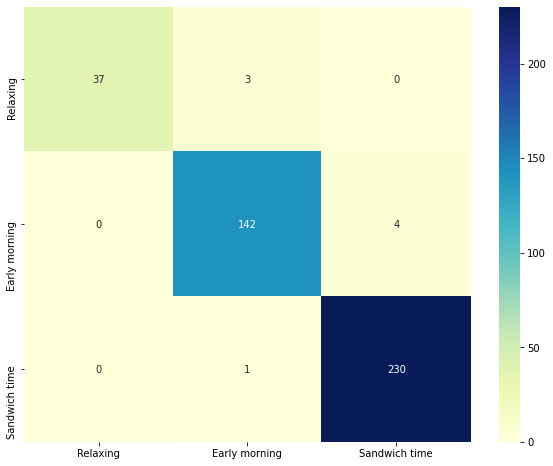

In [51]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
# activity_list = hi_idToLabel
df_cm = pd.DataFrame(confm, index=_activity_map.values(), columns=_activity_map.values())
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

# VAE [Novelty Detection]

In [52]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_7
combined_sensor_self_attention_1
dense_112


In [53]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [54]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 25, 77)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 787200    
_________________________________________________________________
modality_encoder_block_7 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82944     
Total params: 974,144
Trainable params: 0
Non-trainable params: 974,144
_________________________________________________________________


In [55]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=32,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data, _ = self.base_model(data)
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

            reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(data, reconstructed))
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [56]:
hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=64)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

In [58]:
vae_history = hsa_vae.fit(X_train, epochs=50, batch_size=64)

Epoch 1/50
26/26 [==============================] - 2s 94ms/step - loss: 1.4460 - reconstruction_loss: 1.2543 - kl_loss: 0.1917
Epoch 2/50
26/26 [==============================] - 3s 96ms/step - loss: 1.1940 - reconstruction_loss: 1.1666 - kl_loss: 0.0275
Epoch 3/50
26/26 [==============================] - 2s 92ms/step - loss: 1.1031 - reconstruction_loss: 1.0861 - kl_loss: 0.0170
Epoch 4/50
26/26 [==============================] - 2s 94ms/step - loss: 1.0300 - reconstruction_loss: 1.0073 - kl_loss: 0.0226
Epoch 5/50
26/26 [==============================] - 2s 94ms/step - loss: 0.9715 - reconstruction_loss: 0.9445 - kl_loss: 0.0270
Epoch 6/50
26/26 [==============================] - 3s 99ms/step - loss: 0.9452 - reconstruction_loss: 0.9157 - kl_loss: 0.0296
Epoch 7/50
26/26 [==============================] - 3s 99ms/step - loss: 0.9110 - reconstruction_loss: 0.8744 - kl_loss: 0.0366
Epoch 8/50
26/26 [==============================] - 3s 102ms/step - loss: 0.8910 - reconstruction_loss: 

## Novelty Result

In [59]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])

In [60]:
def kl_div(z_mean, z_log_var):
    kl_loss = -0.5 * tf.math.reduce_mean((z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1), axis=1)
    return kl_loss.numpy()

In [61]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_train)[0])
train_kl = kl_div(z_mean, z_log_var)

In [62]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_test)[0])
test_kl = kl_div(z_mean, z_log_var)

In [63]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])
holdout_kl = kl_div(z_mean, z_log_var)

In [64]:
def novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.25):
    threshold = np.mean(train_kl) - (mult * np.std(train_kl))
    
    y_holdout = (holdout_kl > threshold).astype(int)
    y_true = np.ones(shape=holdout_kl.shape, dtype=int)
    
    y_test_n = (test_kl > threshold).astype(int)
    _y_true = np.zeros(shape=test_kl.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
#     return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro')
    
    print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [77]:
novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.75)

              precision    recall  f1-score   support

       KNOWN       0.12      0.06      0.08       417
       NOVEL       0.65      0.80      0.72       916

    accuracy                           0.57      1333
   macro avg       0.39      0.43      0.40      1333
weighted avg       0.49      0.57      0.52      1333



In [68]:
train_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_train)[0], hsa_vae.predict(X_train)).numpy()
test_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_test)[0], hsa_vae.predict(X_test)).numpy()
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout)).numpy()

In [69]:
def novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=0.25):
    threshold = np.mean(train_rec_loss) - (mult * np.std(train_rec_loss))
    
    y_holdout = (novel_rec_loss > threshold).astype(int)
    y_true = np.ones(shape=novel_rec_loss.shape, dtype=int)
    
    y_test_n = (test_rec_loss > threshold).astype(int)
    _y_true = np.zeros(shape=test_rec_loss.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
    return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro'), 
    
#     print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [70]:
def hparam_search():
    table = list()
    thresh_vals = list(np.arange(0.0, 1.01, 0.01))
    
    idx = 0
    
    for m_val in thresh_vals:
        result = novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=m_val)
        table.append([idx, m_val, result[0], result[1]])
        
        idx = idx + 1
    
    table = np.array(table)
    sns.lineplot(table[:, 1], table[:, 2], label='Accuracy')
    sns.lineplot(table[:, 1], table[:, 3], label='Macro F1')
    plt.xlabel('Hyperparameter Value')
    plt.title('Novelty Detection Experiement')
    plt.show()
    
    top_acc = np.array(pd.Series(table[:, 2]).nlargest().index)
    top_f1 = np.array(pd.Series(table[:, 3]).nlargest().index)
    
    print('Index with Top Accuracy and Macro F1 : ', top_acc, top_f1)
    print('Most Important Index : ', np.intersect1d(top_acc, top_f1))
    
    print(tabulate(table, headers=['Index', 'Std. Multiplier Value', 'Accuracy', 'Macro F1'], tablefmt="grid"))

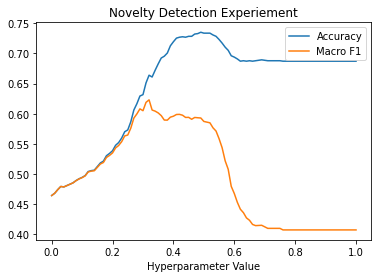

Index with Top Accuracy and Macro F1 :  [49 50 51 52 48] [32 31 29 33 30]
Most Important Index :  []
+---------+-------------------------+------------+------------+
|   Index |   Std. Multiplier Value |   Accuracy |   Macro F1 |
+=========+=========================+============+============+
|       0 |                    0    |   0.464366 |   0.464279 |
+---------+-------------------------+------------+------------+
|       1 |                    0.01 |   0.468117 |   0.468087 |
+---------+-------------------------+------------+------------+
|       2 |                    0.02 |   0.474119 |   0.474117 |
+---------+-------------------------+------------+------------+
|       3 |                    0.03 |   0.47937  |   0.479355 |
+---------+-------------------------+------------+------------+
|       4 |                    0.04 |   0.47862  |   0.47859  |
+---------+-------------------------+------------+------------+
|       5 |                    0.05 |   0.48087  |   0.480821 |
+--

In [73]:
# Result
hparam_search() 

## Attention maps

In [ ]:
np.save('opp_benm_preds.npy', np.argmax(pred, axis=1))

In [ ]:
['BACK', 'RUA', 'RLA', 'LUA', 'LLA', 'L-SHOE', 'R-SHOE']

['BACK', 'RUA', 'RLA', 'LUA', 'LLA', 'L-SHOE', 'R-SHOE']

In [ ]:
window_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("multi_window_encoder").output)
session_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("combined_sensor_self_attention_1").output)

In [ ]:
_, w_out = window_model.predict(X_test)
_, s_out = session_model.predict(X_test)

In [ ]:
np.save('opp_benm_window.npy', w_out)
np.save('opp_benm_session.npy', s_out)

In [ ]:
idx = 97
example = X_test[idx]
example = example[np.newaxis, :]
_, aa1 = window_model.predict(example)
_, aa2 = session_model.predict(example)

In [ ]:
aa1.shape

(1, 252, 25)

In [ ]:
aa2.shape

(1, 1, 36)

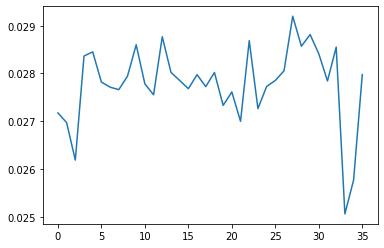

In [ ]:
plt.plot(aa2.flatten())